In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/202076fraud2/test_dummy_with_nan.csv
/kaggle/input/202076fraud2/read_me.txt
/kaggle/input/202076fraud2/test_dummy_fill_nan_with_0.csv
/kaggle/input/202076fraud2/train_dummy_with_nan.csv
/kaggle/input/202076fraud2/train_dummy_with_nan_1000lines.csv
/kaggle/input/202076fraud2/train_dummy_fill_nan_with_0.csv
/kaggle/input/202076fraud2/test_dummy_with_nan_1000lines.csv


In [76]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier

In [25]:
gc.collect()

20

In [83]:
train = pd.read_csv('/kaggle/input/202076fraud2/train_dummy_fill_nan_with_0.csv',index_col=0)
test = pd.read_csv('/kaggle/input/202076fraud2/test_dummy_fill_nan_with_0.csv',index_col=0)

In [4]:
train.drop(columns=['TransactionID'],inplace=True)
test.drop(columns=['TransactionID'],inplace=True)

### 需要标准化的列 --把不是独热向量的全标准化了

In [5]:
need_stand_col = []
for a_column in list(train.columns):
    if list(train[a_column].drop_duplicates())!= [0,1]:
        need_stand_col.append(a_column)

##### 查看需要标准化的列

In [6]:
need_stand_col

['TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86'

### 标准化

In [6]:
for col in need_stand_col:
    scaler = StandardScaler()
    train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))

In [17]:
for col in need_stand_col:
    scaler = StandardScaler()
    test[col] = scaler.fit_transform(test[col].values.reshape(-1, 1))

In [ ]:
"""scaler = StandardScaler()
train[need_stand_col] = scaler.fit_transform(train[need_stand_col])
test[need_stand_col] = scaler.fit_transform(test[need_stand_col])"""

In [14]:
train.head()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,R_emaildomain_suffix_nan,R_emaildomain_suffix_uk,R_emaildomain_suffix_us,id_30_new_Android,id_30_new_Linux,id_30_new_Mac,id_30_new_Windows,id_30_new_func,id_30_new_iOS,id_30_new_other
0,0.0,-1.577987,-0.278167,0.821695,-2.194286,-0.202222,-1.257118,0.427260,0.359582,-0.118444,...,0.550367,0,0,0,0,0,0,0,0,0
1,0.0,-1.577986,-0.443327,-1.457558,0.288389,-0.202222,-2.157605,0.502728,0.359582,-0.196550,...,0.550367,0,0,0,0,0,0,0,0,0
2,0.0,-1.577972,-0.317889,-1.068263,0.816879,-0.202222,-0.716826,0.540462,0.359582,0.983253,...,0.550367,0,0,0,0,0,0,0,0,0
3,0.0,-1.577965,-0.355521,1.679858,1.290062,-0.202222,-1.819922,1.642300,0.359582,-0.196550,...,0.550367,0,0,0,0,0,0,0,0,0
4,0.0,-1.577964,-0.355521,-1.102133,0.964364,-0.202222,-2.157605,1.219677,0.359582,-0.196550,...,0.550367,0,0,1,0,0,0,0,0,0


In [27]:
test.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,R_emaildomain_suffix_nan,R_emaildomain_suffix_uk,R_emaildomain_suffix_us,id_30_new_Android,id_30_new_Linux,id_30_new_Mac,id_30_new_Windows,id_30_new_func,id_30_new_iOS,id_30_new_other
0,-1.792644,-0.418162,0.092483,-1.501041,-0.153925,0.619939,-0.615198,0.393377,-0.172103,-0.105732,...,0.605312,0,0,0,0,0,0,0,0,0
1,-1.792635,-0.348790,-1.163823,-1.501041,-0.153925,0.619939,0.328933,0.393377,-0.157771,-0.105732,...,0.605312,0,0,0,0,0,0,0,0,0
2,-1.792626,0.147589,-1.122062,1.318096,-0.153925,0.619939,1.595094,0.393377,12.411283,-0.105732,...,0.605312,0,0,0,0,0,0,0,0,0
3,-1.792626,0.611216,0.211215,0.015082,-0.153925,-0.726131,-0.359039,0.393377,-0.095666,-0.105732,...,0.605312,0,0,0,0,0,0,0,0,0
4,-1.792624,-0.271689,1.650123,0.575256,-0.153925,-1.825422,0.072774,0.393377,-0.148216,-0.105732,...,0.605312,0,0,0,0,0,0,0,0,0


### 主成分分析

In [7]:
pca = PCA()
pca.fit(train.drop(columns=['isFraud']))

PCA()

#### 查看主成分分析 方差大小占总体比例

<BarContainer object of 506 artists>

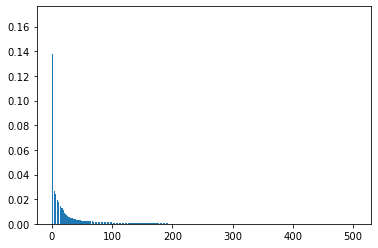

In [14]:
plt.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)

In [20]:
pca.explained_variance_ratio_

array([1.68043270e-01, 1.37661771e-01, 7.92798673e-02, 3.97071286e-02,
       2.69023559e-02, 2.47746195e-02, 2.39308242e-02, 2.14975908e-02,
       2.05464900e-02, 1.91183040e-02, 1.88880348e-02, 1.78536571e-02,
       1.70205245e-02, 1.54718613e-02, 1.41137775e-02, 1.38952476e-02,
       1.27743423e-02, 1.24432335e-02, 1.11555664e-02, 1.09948368e-02,
       1.00974977e-02, 8.49279256e-03, 7.91879616e-03, 7.56004217e-03,
       7.24542901e-03, 6.73276235e-03, 6.22642654e-03, 5.67328104e-03,
       5.20353482e-03, 5.12506694e-03, 4.86130765e-03, 4.82128753e-03,
       4.62713770e-03, 4.34613043e-03, 4.32376440e-03, 4.21559937e-03,
       4.01838484e-03, 3.81483933e-03, 3.80560004e-03, 3.73299975e-03,
       3.42288426e-03, 3.40933408e-03, 3.25499604e-03, 3.14986060e-03,
       2.90646830e-03, 2.85639107e-03, 2.79081717e-03, 2.70626445e-03,
       2.62439336e-03, 2.60580487e-03, 2.52836989e-03, 2.48255742e-03,
       2.41079724e-03, 2.38542420e-03, 2.34742879e-03, 2.32036970e-03,
      

In [23]:
n_components_list = []
sum_variance_ratio_list = []
sum_var_ratio = 0
for i,var_ratio in enumerate(pca.explained_variance_ratio_):
    sum_var_ratio += var_ratio
    n_components_list.append(i+1)
    sum_variance_ratio_list.append(sum_var_ratio)

components_and_ratio = pd.DataFrame({'n_components':n_components_list,'sum_variance_ratio':sum_variance_ratio_list })

### 取前75个主成分可以使得方差总和达到0.9

In [33]:
components_and_ratio.iloc[70:80]

,n_components,sum_variance_ratio
70,71,0.893783
71,72,0.895596
72,73,0.897380
73,74,0.899113
74,75,0.900815
75,76,0.902483
76,77,0.904127
77,78,0.905704
78,79,0.907266
79,80,0.908820


In [39]:
pca = PCA(n_components=74)
pca.fit(train.drop(columns=['isFraud']))

PCA(n_components=74)

#### 导出pca

In [42]:
joblib.dump(pca,'pca74.pkl')

['pca74.pkl']

#### 导入pca,用在train和test上

In [50]:
my_pca = joblib.load('./pca74.pkl')
train_new = my_pca.fit_transform(train.drop(columns=['isFraud']))
test_new = my_pca.fit_transform(test)

In [78]:
pd.DataFrame(train_new).to_csv('train_new.csv',index=False)

In [49]:
train.head()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,R_emaildomain_suffix_nan,R_emaildomain_suffix_uk,R_emaildomain_suffix_us,id_30_new_Android,id_30_new_Linux,id_30_new_Mac,id_30_new_Windows,id_30_new_func,id_30_new_iOS,id_30_new_other
0,0.0,-1.577987,-0.278167,0.821695,-2.194286,-0.202222,-1.257118,0.427260,0.359582,-0.118444,...,0.550367,0,0,0,0,0,0,0,0,0
1,0.0,-1.577986,-0.443327,-1.457558,0.288389,-0.202222,-2.157605,0.502728,0.359582,-0.196550,...,0.550367,0,0,0,0,0,0,0,0,0
2,0.0,-1.577972,-0.317889,-1.068263,0.816879,-0.202222,-0.716826,0.540462,0.359582,0.983253,...,0.550367,0,0,0,0,0,0,0,0,0
3,0.0,-1.577965,-0.355521,1.679858,1.290062,-0.202222,-1.819922,1.642300,0.359582,-0.196550,...,0.550367,0,0,0,0,0,0,0,0,0
4,0.0,-1.577964,-0.355521,-1.102133,0.964364,-0.202222,-2.157605,1.219677,0.359582,-0.196550,...,0.550367,0,0,1,0,0,0,0,0,0


In [54]:
print(train_new.shape)
print(train.shape)

(590540, 74)
(590540, 507)


### 分割训练集和测试集

In [57]:
X_train,X_test,y_train,y_test = train_test_split(train_new,train['isFraud'],random_state=2333)

#### catboosing

In [72]:
cat = CatBoostClassifier(class_weights=[1,30])
cat.fit(X_train, y_train,use_best_model=True) #iterations=

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.138966
0:	learn: 0.6463317	total: 271ms	remaining: 4m 31s
1:	learn: 0.6124411	total: 472ms	remaining: 3m 55s
2:	learn: 0.5858619	total: 671ms	remaining: 3m 43s
3:	learn: 0.5662636	total: 872ms	remaining: 3m 37s
4:	learn: 0.5542785	total: 1.05s	remaining: 3m 30s
5:	learn: 0.5438564	total: 1.23s	remaining: 3m 24s
6:	learn: 0.5356843	total: 1.43s	remaining: 3m 22s
7:	learn: 0.5297237	total: 1.6s	remaining: 3m 18s
8:	learn: 0.5233344	total: 1.81s	remaining: 3m 19s
9:	learn: 0.5185620	total: 2.07s	remaining: 3m 25s
10:	learn: 0.5136988	total: 2.25s	remaining: 3m 22s
11:	learn: 0.5105187	total: 2.44s	remaining: 3m 21s
12:	learn: 0.5073678	total: 2.63s	remaining: 3m 19s
13:	learn: 0.5048737	total: 2.81s	remaining: 3m 18s
14:	learn: 0.5022523	total: 3s	remaining: 3m 16s
15:	learn: 0.5003592	total: 3.18s	remaining: 3m 15s
16:	learn: 0.4988769	total: 3.37s	remaining: 3m 14s
17:	learn: 0.4968718	total: 3.56s	remaining: 3m 14s
18:	learn: 0.4947602	total: 3.77s	remaining: 3m 

159:	learn: 0.3992667	total: 32.5s	remaining: 2m 50s
160:	learn: 0.3987965	total: 32.7s	remaining: 2m 50s
161:	learn: 0.3982939	total: 32.9s	remaining: 2m 50s
162:	learn: 0.3978341	total: 33.1s	remaining: 2m 49s
163:	learn: 0.3973872	total: 33.3s	remaining: 2m 49s
164:	learn: 0.3968957	total: 33.5s	remaining: 2m 49s
165:	learn: 0.3965141	total: 33.6s	remaining: 2m 49s
166:	learn: 0.3961150	total: 33.8s	remaining: 2m 48s
167:	learn: 0.3956862	total: 34s	remaining: 2m 48s
168:	learn: 0.3952358	total: 34.2s	remaining: 2m 48s
169:	learn: 0.3948323	total: 34.4s	remaining: 2m 48s
170:	learn: 0.3943748	total: 34.6s	remaining: 2m 47s
171:	learn: 0.3939654	total: 34.8s	remaining: 2m 47s
172:	learn: 0.3935322	total: 35.1s	remaining: 2m 47s
173:	learn: 0.3931348	total: 35.3s	remaining: 2m 47s
174:	learn: 0.3926782	total: 35.5s	remaining: 2m 47s
175:	learn: 0.3921678	total: 35.7s	remaining: 2m 47s
176:	learn: 0.3917374	total: 35.9s	remaining: 2m 46s
177:	learn: 0.3912109	total: 36.1s	remaining: 2m

315:	learn: 0.3445968	total: 1m 3s	remaining: 2m 17s
316:	learn: 0.3443177	total: 1m 3s	remaining: 2m 16s
317:	learn: 0.3441048	total: 1m 3s	remaining: 2m 16s
318:	learn: 0.3438209	total: 1m 3s	remaining: 2m 16s
319:	learn: 0.3435672	total: 1m 4s	remaining: 2m 16s
320:	learn: 0.3432915	total: 1m 4s	remaining: 2m 16s
321:	learn: 0.3430406	total: 1m 4s	remaining: 2m 15s
322:	learn: 0.3427302	total: 1m 4s	remaining: 2m 15s
323:	learn: 0.3424754	total: 1m 4s	remaining: 2m 15s
324:	learn: 0.3421015	total: 1m 5s	remaining: 2m 15s
325:	learn: 0.3419028	total: 1m 5s	remaining: 2m 15s
326:	learn: 0.3416095	total: 1m 5s	remaining: 2m 14s
327:	learn: 0.3412922	total: 1m 5s	remaining: 2m 14s
328:	learn: 0.3410769	total: 1m 5s	remaining: 2m 14s
329:	learn: 0.3408029	total: 1m 6s	remaining: 2m 14s
330:	learn: 0.3405165	total: 1m 6s	remaining: 2m 14s
331:	learn: 0.3402800	total: 1m 6s	remaining: 2m 13s
332:	learn: 0.3399272	total: 1m 6s	remaining: 2m 13s
333:	learn: 0.3397068	total: 1m 6s	remaining: 

469:	learn: 0.3063018	total: 1m 35s	remaining: 1m 47s
470:	learn: 0.3060987	total: 1m 35s	remaining: 1m 46s
471:	learn: 0.3058902	total: 1m 35s	remaining: 1m 46s
472:	learn: 0.3056511	total: 1m 35s	remaining: 1m 46s
473:	learn: 0.3054649	total: 1m 35s	remaining: 1m 46s
474:	learn: 0.3052811	total: 1m 36s	remaining: 1m 46s
475:	learn: 0.3050718	total: 1m 36s	remaining: 1m 45s
476:	learn: 0.3048619	total: 1m 36s	remaining: 1m 45s
477:	learn: 0.3046721	total: 1m 36s	remaining: 1m 45s
478:	learn: 0.3044398	total: 1m 36s	remaining: 1m 45s
479:	learn: 0.3042186	total: 1m 37s	remaining: 1m 45s
480:	learn: 0.3040295	total: 1m 37s	remaining: 1m 44s
481:	learn: 0.3037945	total: 1m 37s	remaining: 1m 44s
482:	learn: 0.3035615	total: 1m 37s	remaining: 1m 44s
483:	learn: 0.3033553	total: 1m 37s	remaining: 1m 44s
484:	learn: 0.3031640	total: 1m 38s	remaining: 1m 44s
485:	learn: 0.3029633	total: 1m 38s	remaining: 1m 43s
486:	learn: 0.3027271	total: 1m 38s	remaining: 1m 43s
487:	learn: 0.3024657	total:

623:	learn: 0.2766124	total: 2m 6s	remaining: 1m 16s
624:	learn: 0.2764254	total: 2m 6s	remaining: 1m 15s
625:	learn: 0.2762428	total: 2m 6s	remaining: 1m 15s
626:	learn: 0.2760064	total: 2m 6s	remaining: 1m 15s
627:	learn: 0.2758143	total: 2m 6s	remaining: 1m 15s
628:	learn: 0.2756341	total: 2m 7s	remaining: 1m 15s
629:	learn: 0.2754656	total: 2m 7s	remaining: 1m 14s
630:	learn: 0.2752752	total: 2m 7s	remaining: 1m 14s
631:	learn: 0.2751324	total: 2m 7s	remaining: 1m 14s
632:	learn: 0.2749612	total: 2m 8s	remaining: 1m 14s
633:	learn: 0.2747913	total: 2m 8s	remaining: 1m 14s
634:	learn: 0.2746047	total: 2m 8s	remaining: 1m 13s
635:	learn: 0.2744178	total: 2m 8s	remaining: 1m 13s
636:	learn: 0.2742353	total: 2m 8s	remaining: 1m 13s
637:	learn: 0.2740746	total: 2m 9s	remaining: 1m 13s
638:	learn: 0.2738968	total: 2m 9s	remaining: 1m 12s
639:	learn: 0.2737417	total: 2m 9s	remaining: 1m 12s
640:	learn: 0.2735714	total: 2m 9s	remaining: 1m 12s
641:	learn: 0.2733862	total: 2m 9s	remaining: 

778:	learn: 0.2510518	total: 2m 39s	remaining: 45.2s
779:	learn: 0.2509058	total: 2m 39s	remaining: 45s
780:	learn: 0.2508046	total: 2m 39s	remaining: 44.8s
781:	learn: 0.2506710	total: 2m 39s	remaining: 44.6s
782:	learn: 0.2505421	total: 2m 40s	remaining: 44.4s
783:	learn: 0.2503916	total: 2m 40s	remaining: 44.2s
784:	learn: 0.2502258	total: 2m 40s	remaining: 44s
785:	learn: 0.2500783	total: 2m 40s	remaining: 43.8s
786:	learn: 0.2499289	total: 2m 40s	remaining: 43.6s
787:	learn: 0.2497867	total: 2m 41s	remaining: 43.4s
788:	learn: 0.2496702	total: 2m 41s	remaining: 43.2s
789:	learn: 0.2495086	total: 2m 41s	remaining: 43s
790:	learn: 0.2493507	total: 2m 41s	remaining: 42.7s
791:	learn: 0.2492093	total: 2m 41s	remaining: 42.5s
792:	learn: 0.2490751	total: 2m 42s	remaining: 42.3s
793:	learn: 0.2489472	total: 2m 42s	remaining: 42.1s
794:	learn: 0.2487670	total: 2m 42s	remaining: 41.9s
795:	learn: 0.2486091	total: 2m 42s	remaining: 41.7s
796:	learn: 0.2484956	total: 2m 42s	remaining: 41.5s

935:	learn: 0.2290874	total: 3m 11s	remaining: 13.1s
936:	learn: 0.2289333	total: 3m 12s	remaining: 12.9s
937:	learn: 0.2287750	total: 3m 12s	remaining: 12.7s
938:	learn: 0.2286649	total: 3m 12s	remaining: 12.5s
939:	learn: 0.2285434	total: 3m 12s	remaining: 12.3s
940:	learn: 0.2284287	total: 3m 13s	remaining: 12.1s
941:	learn: 0.2282976	total: 3m 13s	remaining: 11.9s
942:	learn: 0.2281744	total: 3m 13s	remaining: 11.7s
943:	learn: 0.2280263	total: 3m 13s	remaining: 11.5s
944:	learn: 0.2279147	total: 3m 13s	remaining: 11.3s
945:	learn: 0.2277620	total: 3m 14s	remaining: 11.1s
946:	learn: 0.2276160	total: 3m 14s	remaining: 10.9s
947:	learn: 0.2275317	total: 3m 14s	remaining: 10.7s
948:	learn: 0.2274265	total: 3m 14s	remaining: 10.5s
949:	learn: 0.2272968	total: 3m 15s	remaining: 10.3s
950:	learn: 0.2271585	total: 3m 15s	remaining: 10.1s
951:	learn: 0.2270811	total: 3m 15s	remaining: 9.86s
952:	learn: 0.2269733	total: 3m 15s	remaining: 9.66s
953:	learn: 0.2268358	total: 3m 16s	remaining:

In [74]:
y_test_predict = cat.predict(X_test)

In [75]:
print(classification_report(y_test,y_test_predict))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95    142379
         1.0       0.25      0.71      0.37      5256

    accuracy                           0.91    147635
   macro avg       0.62      0.82      0.66    147635
weighted avg       0.96      0.91      0.93    147635



#### XGBoosting

In [80]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
y_test_predict_xgb = xgb.predict(X_test)

In [82]:
print(classification_report(y_test,y_test_predict_xgb))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    142379
         1.0       0.85      0.32      0.47      5256

    accuracy                           0.97    147635
   macro avg       0.91      0.66      0.73    147635
weighted avg       0.97      0.97      0.97    147635

